# Testing production and degradation on ABC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

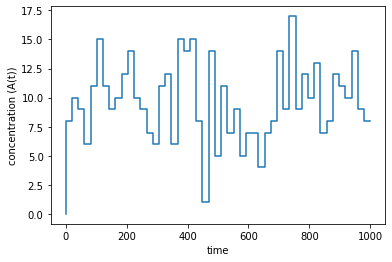

In [3]:
np.random.seed(7)

# Load a forward model
n_0 = 0
model = toy.stochastic.ProductionDegradationModel(n_0)

# Create some toy data
k = [0.1, 1]
times = np.linspace(0, 1000, 50)

values = model.simulate(k, times)
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)
# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0, 0.5], [0.3, 2])
# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

# Calculating the posterior

In [4]:
import math

# Single stationary distribution
def s_stationary(theta, n):
    fct = math.factorial(n)
    frac = theta[1] / theta[0]
    return (frac ** n) * np.exp(-frac) / fct

def p_stationary(theta, data):
    prod = 1.0
    for d in data:
        prod *= s_stationary(theta, d[0])
    return prod

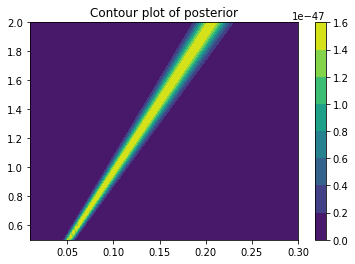

In [5]:
xlist = np.linspace(0.01, 0.3, 100)
ylist = np.linspace(0.5, 2, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = [[p_stationary([x, y], values[10:]) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute integral

In [6]:
from scipy import integrate

def f(x, y):
    return p_stationary([x, y], values[10:])

def bounds_x(y):
    return [0.0, 0.3]

def bounds_y():
    return [0.5, 2]

res = integrate.nquad(f, [bounds_x, bounds_y])

print("integral is ="+str(res))

def normalized_posterior(x, y):
    return p_stationary([x, y], values[10:]) / res[0]

new_approx = integrate.nquad(normalized_posterior, [bounds_x, bounds_y])

print("new integral should be 1="+str(new_approx))


integral is =(3.9473804110212486e-49, 5.696996805929298e-49)
new integral should be 1=(0.9982564874830195, 1.1142026796040793e-08)


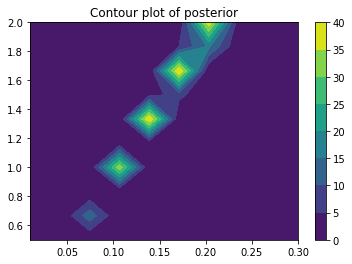

In [7]:
xlist = np.linspace(0.01, 0.3, 10)
ylist = np.linspace(0.5, 2, 10)
X, Y = np.meshgrid(xlist, ylist)
Z = [[normalized_posterior(x, y) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute marginal distributions

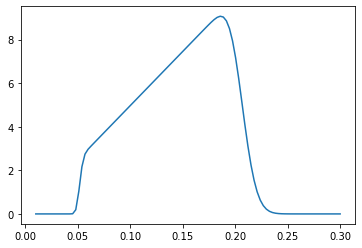

In [9]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.5, 2)[0]

thetas = np.linspace(0.01, 0.3, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_x(theta))

plt.plot(thetas, results)
plt.show()

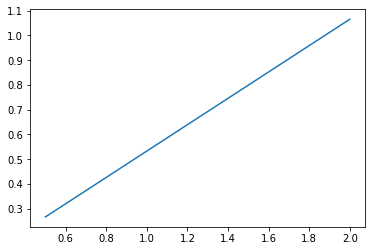

In [10]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.3)[0]

thetas = np.linspace(0.5, 2, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_y(theta))

plt.plot(thetas, results)
plt.show()

# Rejection ABC

In [159]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


error_thresholds = [10, 8, 6, 5]
resulting_kl = []

for error in error_thresholds:
    abc = pints.ABCController(error_measure, log_prior)
    # set threshold
    abc.sampler().set_threshold(error)
    # set target number of samples
    abc.set_n_samples(1000)
    # log to screen
    abc.set_log_to_screen(True)
    print('Running...')
    samples  = abc.run()
    print('Done')

    samples_flat = np.array([item for sublist in samples for item in sublist])

    # computing the KDE and KL functions for x

    def marginal_distribution_x(x):
        partial_lam = lambda y : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0.5, 2)[0]

    def kl_func_x(y, kde_skl):
        part = marginal_distribution_x(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div_x(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_x(y, kde_skl)
        return integrate.quad(fun, 0.013, 0.3)

    saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

    # computing the KDE and KL functions for x
    def marginal_distribution_y(y):
        partial_lam = lambda x : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0, 0.3)[0]

    def kl_func_y(y, kde_skl):
        part = marginal_distribution_y(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved
    
    def kl_div_y(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_y(y, kde_skl)
        return integrate.quad(fun, 0.5, 2)

    saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
    saved = saved_x + saved_y
    resulting_kl.append(saved)

    print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.1
2     2      1                0:00.1
3     3      1                0:00.1
20    28     0.714285714      0:01.3
40    51     0.784313725      0:02.5
60    76     0.789473684      0:03.7
80    101    0.792079208      0:04.8
100   129    0.775193798      0:05.8
120   152    0.789473684      0:06.8
140   174    0.804597701      0:07.7
160   198    0.808080808      0:08.8
180   222    0.810810811      0:09.7
200   250    0.8              0:11.0
220   275    0.8              0:12.0
240   301    0.797342192691   0:13.1
260   323    0.80495356       0:14.0
280   349    0.802292264      0:15.1
300   379    0.791556728      0:16.3
320   403    0.794044665      0:17.3
340   433    0.7852194        0:18.6
360   459    0.784313725      0:19.7
380   480    0.791666667      0:20.6
400   504    0.793650794      0:21.4
420   536    0.78358209       0:22.8
440   560    0.7

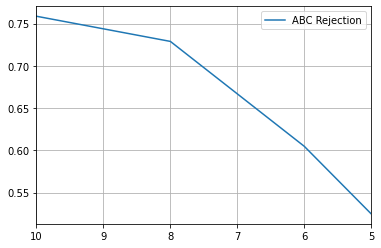

In [161]:
res_rej_abc = resulting_kl

fig, ax = plt.subplots()

ax.plot(error_thresholds, res_rej_abc, label='ABC Rejection')
ax.set_xlim(10, 5)
ax.grid(True)
ax.legend()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')
plt.show()

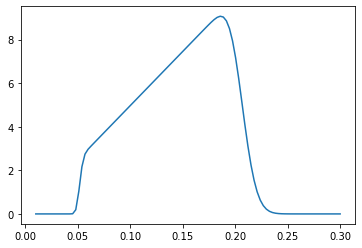

In [138]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.5, 2)[0]

thetas_x = np.linspace(0.01, 0.3, 100)

results_x = []
for theta in thetas_x:
    results_x.append(marginal_distribution_x(theta))

plt.plot(thetas_x, results_x)
plt.show()

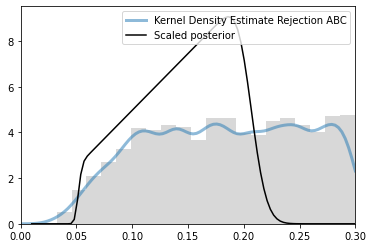

finished computing kde + 0.6187020404830017


In [144]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


# Margin x
fig, ax = plt.subplots(1, 1, sharey=True)
t_samples = np.array([x for y in samples[:, 0] for x in y])

# Computing integral
kde_skl = KernelDensity(bandwidth=0.2)

part_samples = samples_flat[:, 0]
kde_skl.fit(part_samples[:, np.newaxis])


def test_func(x):
    arr = np.array([x])
    res = kde_skl.score_samples(arr[:, np.newaxis])
    return np.exp(res)
    

int_val = integrate.quad(test_func, 0, 0.3)[0]


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_sk = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_sk.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_sk.score_samples(x_grid[:, np.newaxis])

    return np.exp(log_pdf) / int_val

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)


ax.hist(samples_flat[:, 0], 20, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas_x, results_x, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')
plt.show()

# Compute KL divergence
def kl_func_x(y, kde_skl):
    part = marginal_distribution_x(y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        print("something with = "+str(y))
        print("")
        return -np.inf
    else:
        # print("part="+str(part))
        # print("s_part="+str(s_part))
        saved = part * np.log(part / s_part)
        return saved

def kl_div(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_x(y, kde_skl)
    return integrate.quad(fun, 0.013, 0.3)
    
t_samples = np.array([x for x in samples[:, 0]])
saved = kl_div(samples_flat[:, 0], 0.07)[0]
print("finished computing kde + "+str(saved))

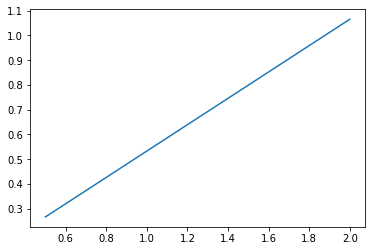

In [141]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.3)[0]

thetas = np.linspace(0.5, 2, 100)

norm_term = integrate.quad(marginal_distribution_y, 0.5, 2)

results_y = []
for theta in thetas:
    results_y.append(marginal_distribution_y(theta))

plt.plot(thetas, results_y)
plt.show()

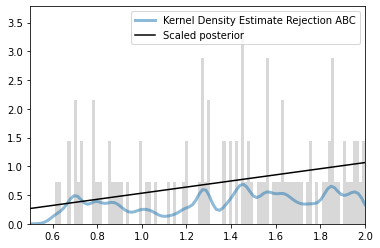

finished computing kde + 0.07535256533417983


In [157]:
# Margin x
fig, ax = plt.subplots(1, 1, sharey=True)
t_samples = np.array([x for y in samples[:, 0] for x in y])

# Computing integral
kde_skl = KernelDensity(bandwidth=0.2)

part_samples = samples_flat[:, 1]
kde_skl.fit(part_samples[:, np.newaxis])


def test_func(x):
    arr = np.array([x])
    res = kde_skl.score_samples(arr[:, np.newaxis])
    return np.exp(res)
    

int_val = integrate.quad(test_func, 0.5, 2)[0]


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_sk = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_sk.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_sk.score_samples(x_grid[:, np.newaxis])

    return np.exp(log_pdf) / int_val

x_grid = np.linspace(0.5, 2, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.03),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)

ax.hist(samples_flat[:, 1], 100, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, results_y, color='black', label='Scaled posterior')
ax.set_xlim(0.5, 2)
ax.legend(loc='upper right')
plt.show()


def marginal_distribution_y(y):
        partial_lam = lambda x : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0, 0.3)[0]

def kl_func_y(y, kde_skl):
    part = marginal_distribution_y(y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        print("something with = "+str(y))
        print("")
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_y(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_y(y, kde_skl)
    return integrate.quad(fun, 0.5, 2)


t_samples = np.array([x for x in samples[:, 0]])
saved = kl_div_y(samples_flat[:, 1], 0.1)[0]
print("finished computing kde + "+str(saved))

# Modified PMC

In [181]:
error_thresholds = [10, 8, 6, 5]
resulting_kl = []

for error in error_thresholds:
    
    np.random.seed(0)
    abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
    # set initial threshold
    abc.sampler().set_threshold_schedule(np.array([1.5 * error, 1.3 * error, error]))

    # produce intermediate distributions of size 200
    abc.sampler().set_intermediate_size(200)

    # set target number of samples
    abc.set_n_samples(1000)

    # log to screen
    abc.set_log_to_screen(True)

    samples = abc.run()
    print("Done")

    samples_flat = np.array([item for item in samples])

    # computing the KDE and KL functions for x
    def marginal_distribution_x(x):
        partial_lam = lambda y : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0.5, 2)[0]

    def kl_func_x(y, kde_skl):
        part = marginal_distribution_x(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div_x(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_x(y, kde_skl)
        return integrate.quad(fun, 0.013, 0.3)

    saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

    # computing the KDE and KL functions for x
    def marginal_distribution_y(y):
        partial_lam = lambda x : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0, 0.3)[0]

    def kl_func_y(y, kde_skl):
        part = marginal_distribution_y(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved
    
    def kl_div_y(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_y(y, kde_skl)
        return integrate.quad(fun, 0.5, 2)

    saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
    saved = saved_x + saved_y
    resulting_kl.append(saved)

    print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=13.0
Trying t=2, threshold=10.0
Iter. Eval. Acceptance rate Time m:s
1     460    0.00217391304    0:20.3
2     461    0.00433839479    0:20.4
3     462    0.00649350649    0:20.4
20    480    0.0416666667     0:21.0
40    503    0.0795228628     0:22.1
60    524    0.114503817      0:23.0
80    545    0.146788991      0:23.8
100   567    0.176366843      0:24.7
120   589    0.203735144      0:25.6
140   611    0.22913257       0:26.3
160   631    0.253565769      0:27.2
180   654    0.275229358      0:28.5
200   674    0.296735905      0:29.3
220   696    0.316091954023   0:30.1
240   718    0.334261838      0:31.0
260   739    0.351826793      0:31.9
280   762    0.367454068      0:32.9
300   785    0.382165605      0:33.8
320   805    0.397515528      0:34.6
340   827    0.411124547      0:35.5
360   849    0.424028269      0:36.4
380   872    0.435779817      0:37.4
400   892    0.448430493      0:38.3
420   913    0.4

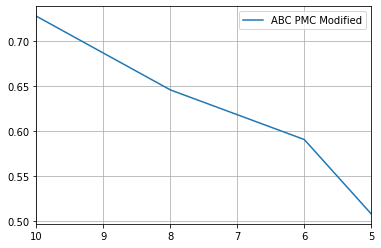

In [183]:
res_fake_pmc = resulting_kl

fig, ax = plt.subplots()

ax.plot(error_thresholds, res_fake_pmc, label='ABC PMC Modified')
ax.set_xlim(10, 5)
ax.grid(True)
ax.legend()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')


# ABC PMC

In [175]:
error_thresholds = [10, 8, 6, 5]
resulting_kl = []

for error in error_thresholds:
    
    np.random.seed(2)
    abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
    # set initial threshold
    abc.sampler().set_threshold_schedule(np.array([1.5 * error, 1.3 * error, error]))

    # produce intermediate distributions of size 200
    abc.sampler().set_intermediate_size(1000)

    # set target number of samples
    abc.set_n_samples(1000)

    # log to screen
    abc.set_log_to_screen(True)

    samples = abc.run()
    print("Done")

    samples_flat = np.array([item for item in samples])


    # computing the KDE and KL functions for x
    def marginal_distribution_x(x):
        partial_lam = lambda y : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0.5, 2)[0]

    def kl_func_x(y, kde_skl):
        part = marginal_distribution_x(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div_x(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_x(y, kde_skl)
        return integrate.quad(fun, 0.013, 0.3)

    saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

    # computing the KDE and KL functions for x
    def marginal_distribution_y(y):
        partial_lam = lambda x : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0, 0.3)[0]

    def kl_func_y(y, kde_skl):
        part = marginal_distribution_y(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved
    
    def kl_div_y(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_y(y, kde_skl)
        return integrate.quad(fun, 0.5, 2)

    saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
    saved = saved_x + saved_y
    resulting_kl.append(saved)

    print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=13.0
Trying t=2, threshold=10.0
Iter. Eval. Acceptance rate Time m:s
1     2293   0.0004361099     1:55.8
2     2294   0.000871839582   1:55.8
3     2295   0.00130718954    1:55.8
20    2314   0.00864304235    1:56.6
40    2337   0.0171159606     1:57.5
60    2360   0.0254237288     1:58.5
80    2380   0.0336134454     1:59.4
100   2402   0.0416319734     2:00.4
120   2423   0.0495253818     2:01.1
140   2449   0.0571661903     2:02.2
160   2473   0.0646987465     2:03.2
180   2494   0.0721732157     2:04.0
200   2518   0.0794281176     2:04.9
220   2538   0.0866824271     2:05.6
240   2561   0.0937133932     2:06.4
260   2582   0.100697134      2:07.1
280   2603   0.107568191      2:07.9
300   2623   0.114372855509   2:08.6
320   2644   0.121028744      2:09.4
340   2664   0.127627628      2:10.3
360   2685   0.134078212      2:11.1
380   2707   0.140376801      2:11.9
400   2728   0.146627566      2:12.7
420   2751   0.1

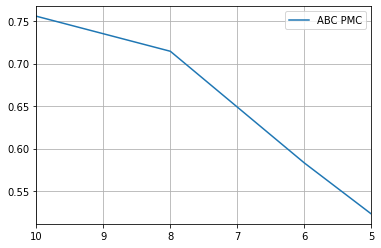

In [177]:
res_true_pmc = resulting_kl

fig, ax = plt.subplots()

ax.plot(error_thresholds, res_true_pmc, label='ABC PMC')
ax.set_xlim(10, 5)
ax.grid(True)
ax.legend()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')

# All errors

[0.7279671925068255, 0.6459892842095734, 0.5907803637138013, 0.5079935375670638]


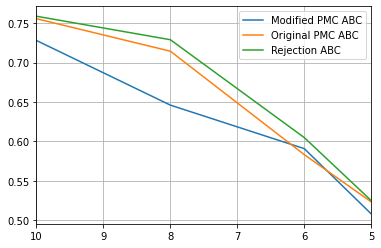

In [184]:
fig, ax = plt.subplots()

print(res_fake_pmc)

ax.plot(error_thresholds, res_fake_pmc, label='Modified PMC ABC')
ax.plot(error_thresholds, res_true_pmc, label='Original PMC ABC')
ax.plot(error_thresholds, res_rej_abc, label='Rejection ABC')
ax.set_xlim(10, 5)
ax.grid(True)
ax.legend()
plt.show()

# import os
# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"
# my_path = os.path.abspath(__file)

# plt.savefig(my_path + '/degradation_errors_all.pdf')

# Adaptive PMC ABC

In [9]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(500)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.1700924  1.28768791]
epsilon=4.685082710048992
w_mean=[0.16528964 1.34771488]
epsilon=4.201190307520001
w_mean=[0.15819193 1.34440431]
epsilon=3.9306488014067096
w_mean=[0.14913046 1.3232475 ]
epsilon=3.7416573867739413
w_mean=[0.14728783 1.30087495]
epsilon=3.605551275463989
w_mean=[0.13950847 1.26636797]
epsilon=3.4856850115866753
w_mean=[0.13559672 1.24740463]
epsilon=3.398529093593286
w_mean=[0.13315816 1.22409532]
epsilon=3.3166247903554
w_mean=[0.12746868 1.19440579]
epsilon=3.263433774416144
w_mean=[0.12761929 1.19489162]
epsilon=3.2093613071762426
w_mean=[0.12501426 1.17639651]
epsilon=3.1622776601683795
w_mean=[0.12440638 1.16904729]
epsilon=3.122498999199199
w_mean=[0.12031688 1.13541359]
epsilon=3.0740852297878796
w_mean=[0.12017047 1.13620195]
epsilon=3.0413812651491097
w_mean=[0.12030749 1.13183294]
epsilon=3.0
w_mean=[0.1185371  1.11534026]
epsilon=2.9748949561287032
w_mean=[0.1185048  1.11762446]
eps

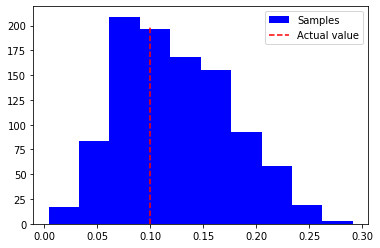

In [10]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
plt.legend()
plt.show()

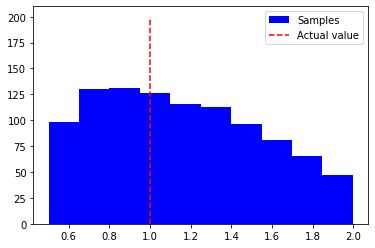

In [11]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
plt.legend()
plt.show()